# **CONFIGURACIÓN**

---



In [ ]:
# Instalar dependencias
!pip install pandas numpy matplotlib seaborn scikit-learn plotly kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
import json
from collections import Counter
import io
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


# **HELPERS**

---

In [ ]:
def calculate_metrics(df):
    """Calcula todas las métricas para un dataframe de resultados"""
    metrics = {}

    # Métricas principales
    for field in ['intent', 'priority', 'route_team']:
        consistent_col = f"{field}_is_consistent"
        if consistent_col in df.columns:
            metrics[f'{field}_accuracy'] = df[consistent_col].mean()

    # Business rules consistency
    metrics['business_rules_consistency'] = df['is_business_rules_consistent'].mean()

    # Performance
    metrics['avg_processing_time_ms'] = df['processing_time_ms'].mean()
    metrics['total_processing_time_s'] = df['processing_time_ms'].sum() / 1000

    # Error rate
    metrics['error_rate'] = (df['error'].fillna('') != '').mean()

    # F1 weighted (para intent)
    if 'intent_predicted' in df.columns and 'intent_example' in df.columns:
        y_true = df['intent_example'].fillna('unknown')
        y_pred = df['intent_predicted'].fillna('unknown')
        metrics['intent_f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return metrics

def get_llm_invocations(strategy_name):
    """Retorna el número de invocaciones al LLM por ticket según la estrategia"""
    invocations_map = {
        'zero_shot': 1,
        'few_shot': 1,
        'cot': 1,
        'cot_sc': 7,  # N=7 muestras + voting
        'tot': 4,     # 1 inicial + 3 candidatos
        'got': 8      # 7 nodos + 1 final
    }
    return invocations_map.get(strategy_name, 1)

print("✅ Funciones auxiliares definidas")

✅ Funciones auxiliares definidas


# **CARGA DE ARCHIVOS CSV**

---



In [ ]:
from google.colab import files
import os

print("📁 PASO 1: Sube los archivos CSV de resultados")
print("="*80)
print("\nFormato de nombres de archivo:")
print("  • {estrategia}_dev_{timestamp}.csv")
print("  • {estrategia}_public_{timestamp}.csv")
print("  • {estrategia}_hidden_{timestamp}.csv")
print("\nEjemplos:")
print("  • zero_shot_dev_20251117_080921.csv")
print("  • zero_shot_public_20251117_081720.csv")
print("  • zero_shot_hidden_20251117_082554.csv")
print("\n💡 Sube todos los archivos que tengas disponibles")
print("   El notebook detectará automáticamente la estrategia y el dataset\n")

# uploaded = files.upload()

folder = "results/"

results = [os.path.join(folder, f) for f in os.listdir(folder)]

# Organizar archivos por estrategia y dataset
data = {
    'dev': {},
    'public': {},
    'hidden': {}
}

for idx, filename in enumerate(results):
    # Detectar dataset type
    if '_dev_' in filename:
        dataset_type = 'dev'
        strategy_name = filename.split('_dev_')[0]
    elif '_public_' in filename:
        dataset_type = 'public'
        strategy_name = filename.split('_public_')[0]
    elif '_hidden_' in filename:
        dataset_type = 'hidden'
        strategy_name = filename.split('_hidden_')[0]
    else:
        print(f"⚠️  No se pudo identificar el dataset de: {filename}")
        continue

    strategy_name = strategy_name.replace("results/", "")

    # Cargar CSV
    df_temp = pd.read_csv(results[idx], sep='|')
    data[dataset_type][strategy_name] = df_temp

    print(f"✅ {dataset_type.upper():8s} | {strategy_name:15s} | {len(df_temp)} ejemplos")

print("\n" + "="*80)
print("📊 RESUMEN DE DATOS CARGADOS:")
print(f"  • dev:    {len(data['dev'])} estrategia(s)")
print(f"  • public: {len(data['public'])} estrategia(s)")
print(f"  • hidden: {len(data['hidden'])} estrategia(s)")
print("="*80)

📁 PASO 1: Sube los archivos CSV de resultados

Formato de nombres de archivo:
  • {estrategia}_dev_{timestamp}.csv
  • {estrategia}_public_{timestamp}.csv
  • {estrategia}_hidden_{timestamp}.csv

Ejemplos:
  • zero_shot_dev_20251117_080921.csv
  • zero_shot_public_20251117_081720.csv
  • zero_shot_hidden_20251117_082554.csv

💡 Sube todos los archivos que tengas disponibles
   El notebook detectará automáticamente la estrategia y el dataset

✅ HIDDEN   | cot             | 5 ejemplos
✅ HIDDEN   | few_shot        | 5 ejemplos
✅ DEV      | zero_shot       | 5 ejemplos
✅ HIDDEN   | zero_shot       | 5 ejemplos
✅ PUBLIC   | few_shot        | 5 ejemplos
✅ DEV      | cot             | 5 ejemplos
✅ PUBLIC   | cot             | 5 ejemplos
✅ PUBLIC   | zero_shot       | 5 ejemplos
✅ DEV      | few_shot        | 5 ejemplos

📊 RESUMEN DE DATOS CARGADOS:
  • dev:    3 estrategia(s)
  • public: 3 estrategia(s)
  • hidden: 3 estrategia(s)


# **MÉTRICAS POR DATASET Y ESTRATEGIA**

---



In [ ]:
# Calcular métricas para cada combinación dataset-estrategia
all_metrics = {}

for dataset_type in ['dev', 'public', 'hidden']:
    all_metrics[dataset_type] = {}

    for strategy_name, df in data[dataset_type].items():
        metrics = calculate_metrics(df)
        metrics['strategy'] = strategy_name
        metrics['dataset'] = dataset_type
        metrics['total_examples'] = len(df)
        metrics['llm_invocations_per_ticket'] = get_llm_invocations(strategy_name)

        all_metrics[dataset_type][strategy_name] = metrics

print("✅ Métricas calculadas para todos los datasets")

✅ Métricas calculadas para todos los datasets


# **TABLA COMPARATIVA: MÉTRICAS POR DATASET**

---



In [ ]:
# Crear tabla comparativa entre datasets
comparison_rows = []

for dataset_type in ['dev', 'public', 'hidden']:
    for strategy_name, metrics in all_metrics[dataset_type].items():
        row = {
            'Dataset': dataset_type.upper(),
            'Estrategia': strategy_name,
            'Intent Acc (%)': metrics['intent_accuracy'] * 100,
            'Priority Acc (%)': metrics['priority_accuracy'] * 100,
            'Route Acc (%)': metrics['route_team_accuracy'] * 100,
            'F1 Weighted (%)': metrics['intent_f1_weighted'] * 100,
            'Business Rules (%)': metrics['business_rules_consistency'] * 100,
            'Avg Time (ms)': metrics['avg_processing_time_ms'],
            'Total Examples': metrics['total_examples']
        }
        comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)

print("\n" + "="*120)
print("TABLA COMPARATIVA: MÉTRICAS POR DATASET Y ESTRATEGIA")
print("="*120 + "\n")

display(comparison_df.style.format({
    'Intent Acc (%)': '{:.2f}',
    'Priority Acc (%)': '{:.2f}',
    'Route Acc (%)': '{:.2f}',
    'F1 Weighted (%)': '{:.2f}',
    'Business Rules (%)': '{:.2f}',
    'Avg Time (ms)': '{:.2f}',
    'Total Examples': '{:.0f}'
}).background_gradient(cmap='RdYlGn', subset=['Intent Acc (%)', 'Priority Acc (%)', 'Route Acc (%)']))

# Exportar
comparison_df.to_csv('tabla_metricas_todos_datasets.csv', index=False)
print("\n✅ Tabla exportada: tabla_metricas_todos_datasets.csv")
print("\n⚠️  IMPORTANTE: Para test_hidden, las métricas se calculan SIN mostrar los textos de los tickets")


TABLA COMPARATIVA: MÉTRICAS POR DATASET Y ESTRATEGIA



,Dataset,Estrategia,Intent Acc (%),Priority Acc (%),Route Acc (%),F1 Weighted (%),Business Rules (%),Avg Time (ms),Total Examples
0,DEV,zero_shot,100.00,60.00,100.00,100.00,40.00,77.25,5
1,DEV,cot,80.00,80.00,80.00,80.00,40.00,68.08,5
2,DEV,few_shot,100.00,80.00,100.00,100.00,40.00,87.81,5
3,PUBLIC,few_shot,100.00,60.00,100.00,100.00,0.00,121.11,5
4,PUBLIC,cot,100.00,40.00,100.00,100.00,20.00,77.60,5
5,PUBLIC,zero_shot,100.00,80.00,100.00,100.00,20.00,84.32,5
6,HIDDEN,cot,100.00,60.00,100.00,100.00,20.00,63.01,5
7,HIDDEN,few_shot,100.00,60.00,100.00,100.00,0.00,105.34,5
8,HIDDEN,zero_shot,100.00,80.00,100.00,100.00,20.00,85.08,5



✅ Tabla exportada: tabla_metricas_todos_datasets.csv

⚠️  IMPORTANTE: Para test_hidden, las métricas se calculan SIN mostrar los textos de los tickets


# **VISUALIZACIÓN: COMPARACIÓN ENTRE DATASETS**

---



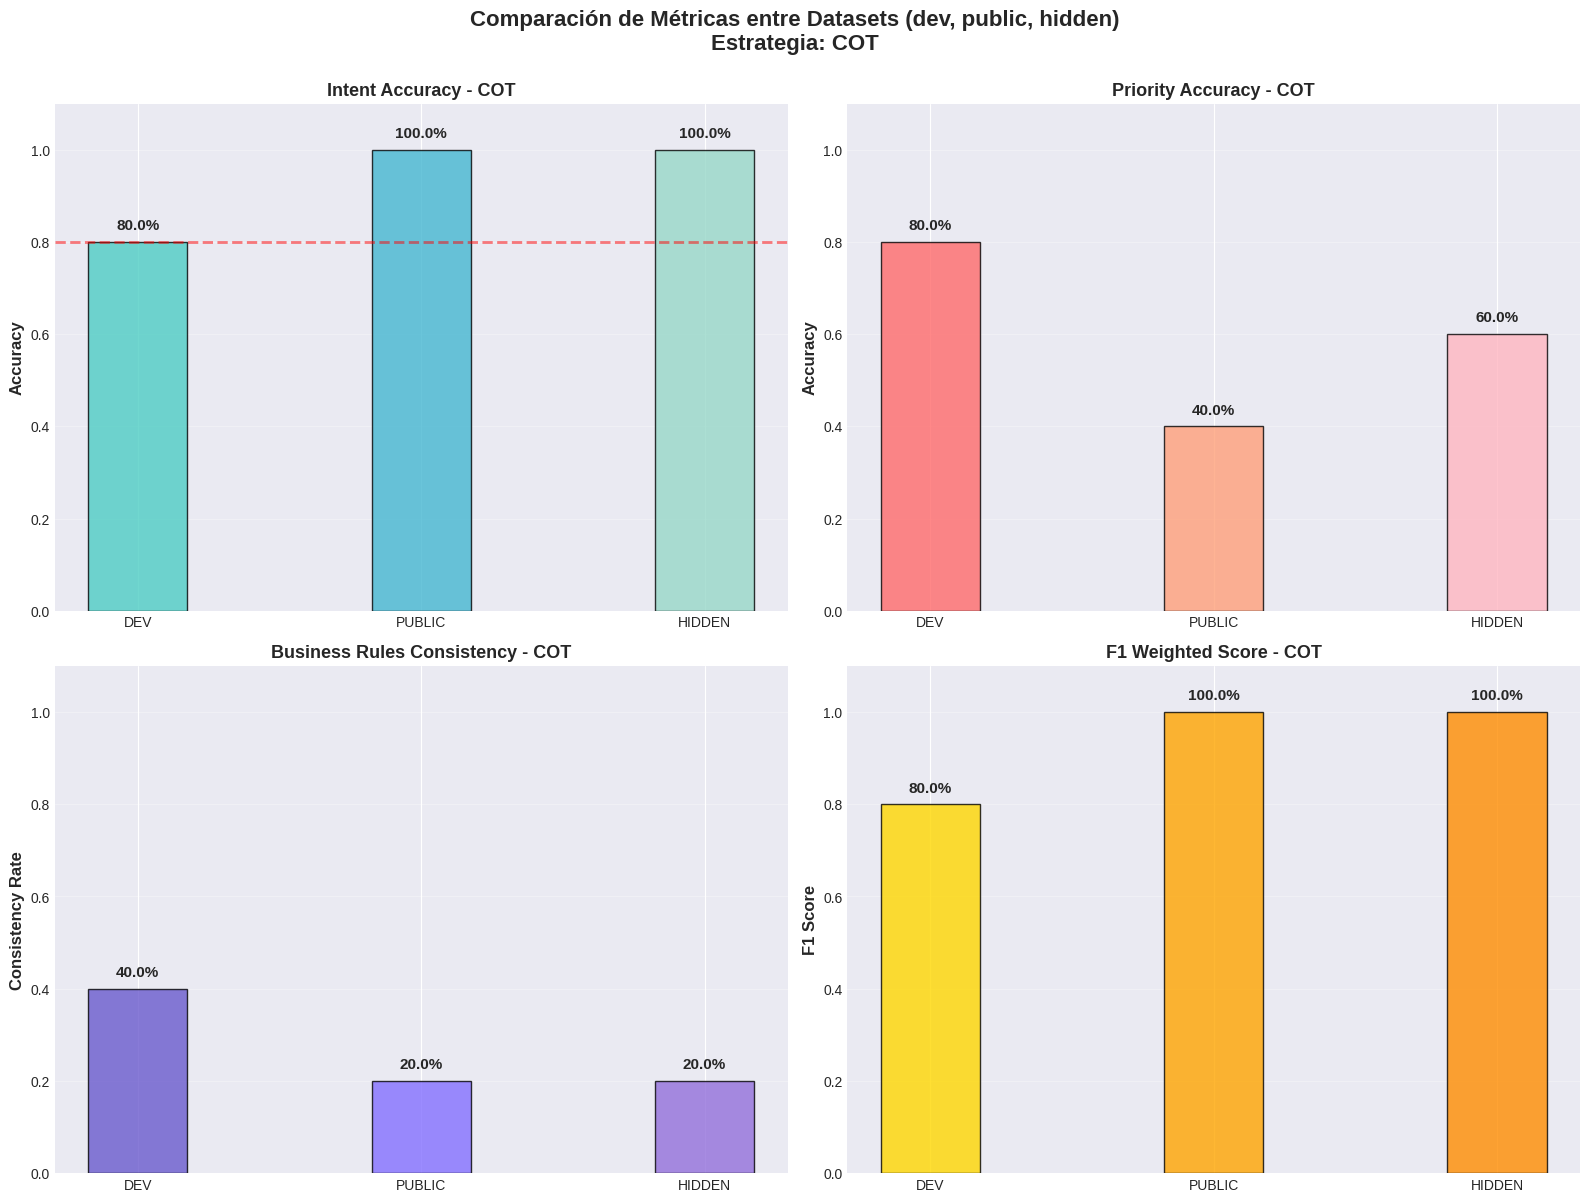


✅ Figura guardada: figura_comparacion_datasets.png
📊 Comparación de COT en los 3 datasets

⚠️  NOTA: Para test_hidden, las métricas se calculan SIN acceso a los textos


In [ ]:
# Gráfico comparando métricas entre dev, public y hidden

# Obtener estrategias únicas
all_strategies = set()
for dataset_type in ['dev', 'public', 'hidden']:
    all_strategies.update(all_metrics[dataset_type].keys())
all_strategies = sorted(list(all_strategies))

if len(all_strategies) > 0:
    # Usar la primera estrategia disponible para comparar datasets
    strategy_to_plot = all_strategies[0]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    datasets = []
    intent_accs = []
    priority_accs = []
    br_consistencies = []
    f1_scores = []

    for dataset_type in ['dev', 'public', 'hidden']:
        if strategy_to_plot in all_metrics[dataset_type]:
            metrics = all_metrics[dataset_type][strategy_to_plot]
            datasets.append(dataset_type.upper())
            intent_accs.append(metrics['intent_accuracy'])
            priority_accs.append(metrics['priority_accuracy'])
            br_consistencies.append(metrics['business_rules_consistency'])
            f1_scores.append(metrics['intent_f1_weighted'])

    x = np.arange(len(datasets))
    width = 0.35

    # Subplot 1: Intent Accuracy
    bars1 = axes[0, 0].bar(x, intent_accs, width, label='Intent Accuracy',
                           color=['#4ECDC4', '#45B7D1', '#98D8C8'], alpha=0.8, edgecolor='black')
    for i, (bar, val) in enumerate(zip(bars1, intent_accs)):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., val + 0.02,
                        f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_title(f'Intent Accuracy - {strategy_to_plot.upper()}', fontsize=13, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(datasets)
    axes[0, 0].set_ylim(0, 1.1)
    axes[0, 0].grid(axis='y', alpha=0.3)
    axes[0, 0].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, linewidth=2)

    # Subplot 2: Priority Accuracy
    bars2 = axes[0, 1].bar(x, priority_accs, width, label='Priority Accuracy',
                           color=['#FF6B6B', '#FFA07A', '#FFB6C1'], alpha=0.8, edgecolor='black')
    for i, (bar, val) in enumerate(zip(bars2, priority_accs)):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., val + 0.02,
                        f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 1].set_title(f'Priority Accuracy - {strategy_to_plot.upper()}', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(datasets)
    axes[0, 1].set_ylim(0, 1.1)
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Subplot 3: Business Rules Consistency
    bars3 = axes[1, 0].bar(x, br_consistencies, width, label='Business Rules',
                           color=['#6A5ACD', '#8470FF', '#9370DB'], alpha=0.8, edgecolor='black')
    for i, (bar, val) in enumerate(zip(bars3, br_consistencies)):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., val + 0.02,
                        f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Consistency Rate', fontsize=12, fontweight='bold')
    axes[1, 0].set_title(f'Business Rules Consistency - {strategy_to_plot.upper()}', fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(datasets)
    axes[1, 0].set_ylim(0, 1.1)
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Subplot 4: F1 Weighted
    bars4 = axes[1, 1].bar(x, f1_scores, width, label='F1 Weighted',
                           color=['#FFD700', '#FFA500', '#FF8C00'], alpha=0.8, edgecolor='black')
    for i, (bar, val) in enumerate(zip(bars4, f1_scores)):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., val + 0.02,
                        f'{val:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    axes[1, 1].set_title(f'F1 Weighted Score - {strategy_to_plot.upper()}', fontsize=13, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(datasets)
    axes[1, 1].set_ylim(0, 1.1)
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.suptitle(f'Comparación de Métricas entre Datasets (dev, public, hidden)\nEstrategia: {strategy_to_plot.upper()}',
                 fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.savefig('figura_comparacion_datasets.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Figura guardada: figura_comparacion_datasets.png")
    print(f"📊 Comparación de {strategy_to_plot.upper()} en los 3 datasets")
    print("\n⚠️  NOTA: Para test_hidden, las métricas se calculan SIN acceso a los textos")

# **EVOLUCIÓN DE ESTRATEGIAS**

---



**Uso de Dev**

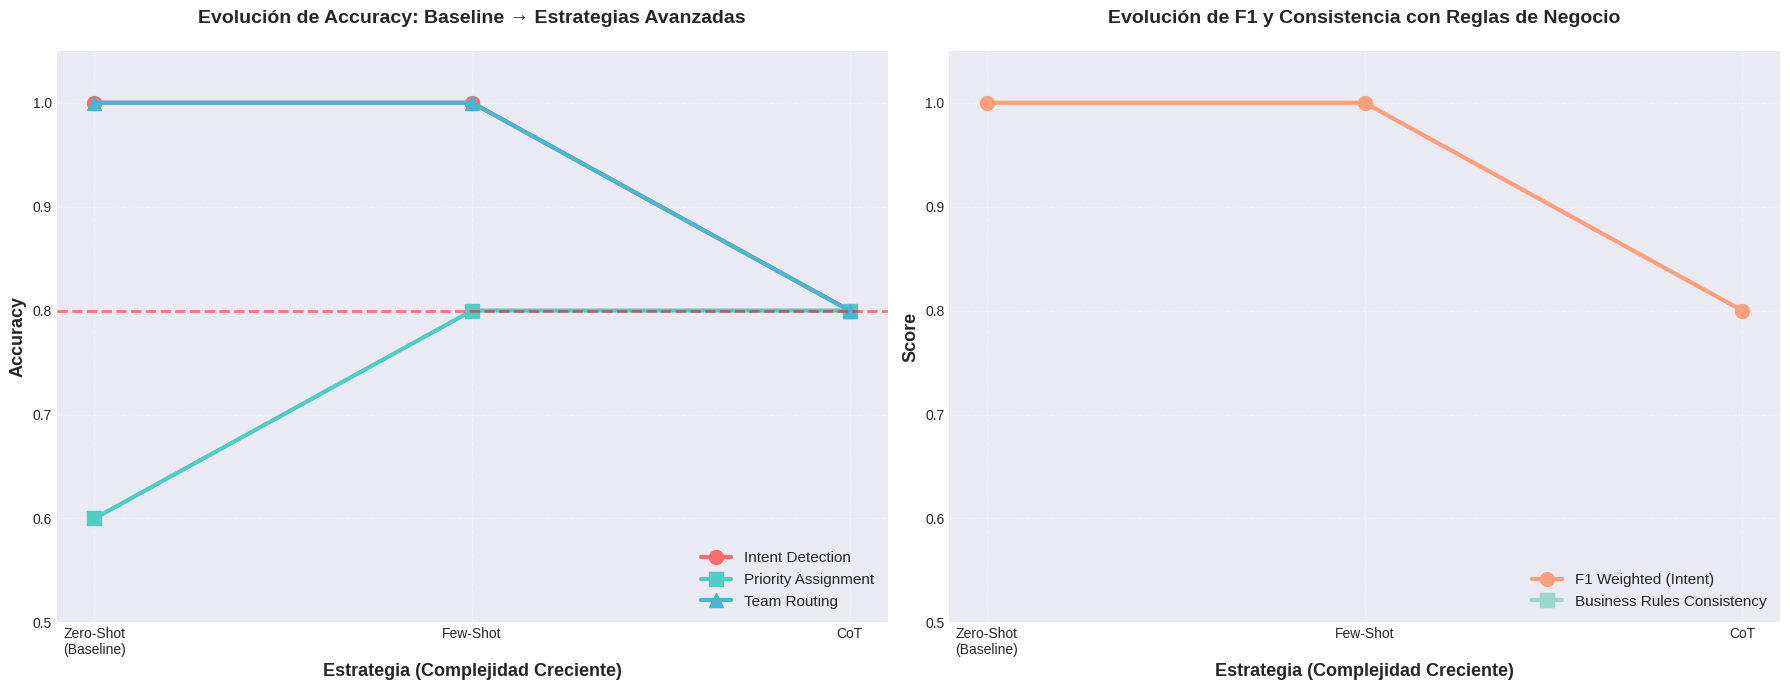


✅ Figura 1 guardada: figura1_evolucion_estrategias.png
📊 Esta figura muestra la mejora progresiva desde Zero-Shot hasta estrategias avanzadas


In [ ]:
# Usar datos de dev para mostrar evolución
if len(data['dev']) > 0:
    # Ordenar estrategias por complejidad
    strategy_order = ['zero_shot', 'few_shot', 'cot', 'cot_sc', 'tot', 'got']
    strategy_labels = ['Zero-Shot\n(Baseline)', 'Few-Shot', 'CoT', 'CoT-SC', 'ToT', 'GoT\n(Avanzada)']

    # Filtrar estrategias disponibles
    available_strategies = [s for s in strategy_order if s in data['dev']]
    available_labels = [strategy_labels[strategy_order.index(s)] for s in available_strategies]

    if len(available_strategies) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(18, 7))

        x = np.arange(len(available_strategies))

        # Extraer métricas
        intent_accs = [all_metrics['dev'][s]['intent_accuracy'] for s in available_strategies]
        priority_accs = [all_metrics['dev'][s]['priority_accuracy'] for s in available_strategies]
        route_accs = [all_metrics['dev'][s]['route_team_accuracy'] for s in available_strategies]
        f1_scores = [all_metrics['dev'][s]['intent_f1_weighted'] for s in available_strategies]
        br_consistencies = [all_metrics['dev'][s]['business_rules_consistency'] for s in available_strategies]

        # Subplot 1: Evolución de Accuracy
        axes[0].plot(x, intent_accs, 'o-', linewidth=3, markersize=10, label='Intent Detection', color='#FF6B6B')
        axes[0].plot(x, priority_accs, 's-', linewidth=3, markersize=10, label='Priority Assignment', color='#4ECDC4')
        axes[0].plot(x, route_accs, '^-', linewidth=3, markersize=10, label='Team Routing', color='#45B7D1')

        axes[0].set_xlabel('Estrategia (Complejidad Creciente)', fontsize=13, fontweight='bold')
        axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
        axes[0].set_title('Evolución de Accuracy: Baseline → Estrategias Avanzadas', fontsize=14, fontweight='bold', pad=20)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(available_labels, fontsize=10)
        axes[0].legend(fontsize=11, loc='lower right')
        axes[0].grid(alpha=0.3, linestyle='--')
        axes[0].set_ylim(0.5, 1.05)
        axes[0].axhline(y=0.8, color='red', linestyle='--', alpha=0.5, linewidth=2)

        # Subplot 2: F1 y Business Rules
        axes[1].plot(x, f1_scores, 'o-', linewidth=3, markersize=10, label='F1 Weighted (Intent)', color='#FFA07A')
        axes[1].plot(x, br_consistencies, 's-', linewidth=3, markersize=10, label='Business Rules Consistency', color='#98D8C8')

        axes[1].set_xlabel('Estrategia (Complejidad Creciente)', fontsize=13, fontweight='bold')
        axes[1].set_ylabel('Score', fontsize=13, fontweight='bold')
        axes[1].set_title('Evolución de F1 y Consistencia con Reglas de Negocio', fontsize=14, fontweight='bold', pad=20)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(available_labels, fontsize=10)
        axes[1].legend(fontsize=11, loc='lower right')
        axes[1].grid(alpha=0.3, linestyle='--')
        axes[1].set_ylim(0.5, 1.05)

        plt.tight_layout()
        plt.savefig('figura1_evolucion_estrategias.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("\n✅ Figura 1 guardada: figura1_evolucion_estrategias.png")
        print("📊 Esta figura muestra la mejora progresiva desde Zero-Shot hasta estrategias avanzadas")
else:
    print("⚠️  No hay datos de dev para mostrar evolución")

# **ANÁLISIS DE COSTO COMPUTACIONAL**

---



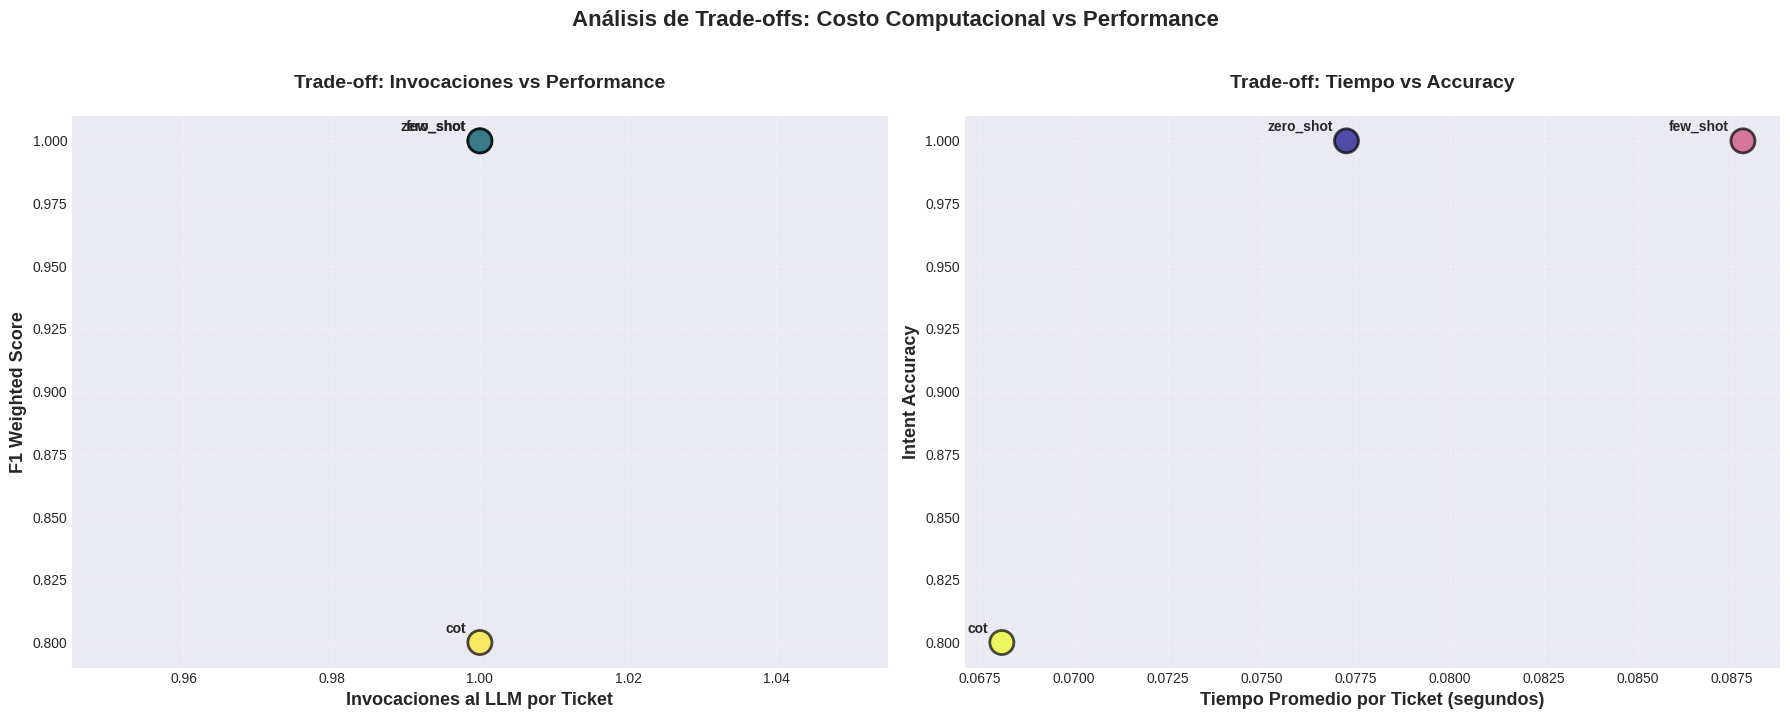


✅ Figura 2 guardada: figura2_tradeoffs_costo.png
📊 Esta figura muestra el balance entre costo computacional y performance


In [ ]:
# Análisis de costos usando datos de dev
if len(data['dev']) > 0 and len(available_strategies) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    invocations = [get_llm_invocations(s) for s in available_strategies]
    times = [all_metrics['dev'][s]['avg_processing_time_ms'] / 1000 for s in available_strategies]

    # Subplot 1: Invocaciones vs F1
    scatter1 = axes[0].scatter(invocations, f1_scores, s=300, c=range(len(invocations)),
                               cmap='viridis', alpha=0.7, edgecolors='black', linewidths=2)

    for i, strat in enumerate(available_strategies):
        axes[0].annotate(strat, (invocations[i], f1_scores[i]),
                         fontsize=10, fontweight='bold', ha='right', va='bottom',
                         xytext=(-10, 5), textcoords='offset points')

    axes[0].set_xlabel('Invocaciones al LLM por Ticket', fontsize=13, fontweight='bold')
    axes[0].set_ylabel('F1 Weighted Score', fontsize=13, fontweight='bold')
    axes[0].set_title('Trade-off: Invocaciones vs Performance', fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(alpha=0.3, linestyle='--')

    # Subplot 2: Tiempo vs Accuracy
    scatter2 = axes[1].scatter(times, intent_accs, s=300, c=range(len(times)),
                               cmap='plasma', alpha=0.7, edgecolors='black', linewidths=2)

    for i, strat in enumerate(available_strategies):
        axes[1].annotate(strat, (times[i], intent_accs[i]),
                         fontsize=10, fontweight='bold', ha='right', va='bottom',
                         xytext=(-10, 5), textcoords='offset points')

    axes[1].set_xlabel('Tiempo Promedio por Ticket (segundos)', fontsize=13, fontweight='bold')
    axes[1].set_ylabel('Intent Accuracy', fontsize=13, fontweight='bold')
    axes[1].set_title('Trade-off: Tiempo vs Accuracy', fontsize=14, fontweight='bold', pad=20)
    axes[1].grid(alpha=0.3, linestyle='--')

    plt.suptitle('Análisis de Trade-offs: Costo Computacional vs Performance',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('figura2_tradeoffs_costo.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n✅ Figura 2 guardada: figura2_tradeoffs_costo.png")
    print("📊 Esta figura muestra el balance entre costo computacional y performance")

# **TABLA DE COSTOS COMPUTACIONALES**

---



In [ ]:
# Crear tabla de costos
if len(data['dev']) > 0 and len(available_strategies) > 0:
    cost_rows = []

    for strategy in available_strategies:
        metrics = all_metrics['dev'][strategy]
        invocations = get_llm_invocations(strategy)

        row = {
            'Estrategia': strategy,
            'LLM Calls/Ticket': invocations,
            'Total Calls (40 ex)': invocations * 40,
            'Avg Time (ms)': metrics['avg_processing_time_ms'],
            'Total Time (s)': metrics['total_processing_time_s'],
            'Intent Acc (%)': metrics['intent_accuracy'] * 100,
            'F1 Score (%)': metrics['intent_f1_weighted'] * 100,
            'Bus. Rules (%)': metrics['business_rules_consistency'] * 100
        }
        cost_rows.append(row)

    cost_df = pd.DataFrame(cost_rows)

    # Calcular costo relativo
    baseline_invocations = cost_df.iloc[0]['LLM Calls/Ticket']
    cost_df['Relative Cost'] = cost_df['LLM Calls/Ticket'] / baseline_invocations

    print("\n" + "="*120)
    print("TABLA DE COSTOS COMPUTACIONALES")
    print("="*120 + "\n")

    display(cost_df.style.format({
        'LLM Calls/Ticket': '{:.0f}',
        'Total Calls (40 ex)': '{:.0f}',
        'Avg Time (ms)': '{:.2f}',
        'Total Time (s)': '{:.2f}',
        'Intent Acc (%)': '{:.2f}',
        'F1 Score (%)': '{:.2f}',
        'Bus. Rules (%)': '{:.2f}',
        'Relative Cost': '{:.1f}x'
    }).background_gradient(cmap='YlOrRd', subset=['LLM Calls/Ticket', 'Avg Time (ms)']))

    cost_df.to_csv('tabla_costos_computacionales.csv', index=False)
    print("\n✅ Tabla exportada: tabla_costos_computacionales.csv")


TABLA DE COSTOS COMPUTACIONALES



,Estrategia,LLM Calls/Ticket,Total Calls (40 ex),Avg Time (ms),Total Time (s),Intent Acc (%),F1 Score (%),Bus. Rules (%),Relative Cost
0,zero_shot,1,40,77.25,0.39,100.00,100.00,40.00,1.0x
1,few_shot,1,40,87.81,0.44,100.00,100.00,40.00,1.0x
2,cot,1,40,68.08,0.34,80.00,80.00,40.00,1.0x



✅ Tabla exportada: tabla_costos_computacionales.csv


# **VERIFICADOR DE BUSINESS VALUE RULES**

---



In [ ]:
# Buscar ejemplos de inconsistencias en dev
if len(data['dev']) > 0:
    first_strategy = list(data['dev'].keys())[0]
    df_dev = data['dev'][first_strategy]

    inconsistent = df_dev[df_dev['is_business_rules_consistent'] == False]

    if len(inconsistent) >= 2:
        print("\n" + "="*120)
        print("EJEMPLOS DE VERIFICADOR CORRIGIENDO INCONSISTENCIAS")
        print("="*120)

        for idx, (_, row) in enumerate(inconsistent.head(2).iterrows(), 1):
            print(f"\n📌 EJEMPLO {idx}: Ticket ID {row['id']}")
            print("\n" + "-"*80)
            print("ANTES (Predicción - INCONSISTENTE):")
            print("-"*80)
            print(f"  Intent:    {row['intent_predicted']}")
            print(f"  Priority:  {row['priority_predicted']}")
            print(f"  Route:     {row['route_team_predicted']}")

            print("\n" + "-"*80)
            print("DESPUÉS (Ground Truth - CONSISTENTE):")
            print("-"*80)
            print(f"  Intent:    {row['intent_example']}")
            print(f"  Priority:  {row['priority_example']}")
            print(f"  Route:     {row['route_team_example']}")

            print("\n" + "-"*80)
            print("ANÁLISIS:")
            print("-"*80)

            if row['intent_predicted'] != row['intent_example']:
                print(f"  ⚠️  Intent: {row['intent_predicted']} → {row['intent_example']}")
            if row['priority_predicted'] != row['priority_example']:
                print(f"  ⚠️  Priority: {row['priority_predicted']} → {row['priority_example']}")
                if row['intent_example'] == 'security':
                    print(f"      → REGLA: intent='security' → P1")
            if row['route_team_predicted'] != row['route_team_example']:
                print(f"  ⚠️  Route: {row['route_team_predicted']} → {row['route_team_example']}")
                print(f"      → REGLA: intent='{row['intent_example']}' → route_team='{row['route_team_example']}'")

        print("\n" + "="*120)
    else:
        print("✅ No se encontraron inconsistencias en dev")
else:
    print("⚠️  No hay datos de dev para analizar verificador")


EJEMPLOS DE VERIFICADOR CORRIGIENDO INCONSISTENCIAS

📌 EJEMPLO 1: Ticket ID T0169

--------------------------------------------------------------------------------
ANTES (Predicción - INCONSISTENTE):
--------------------------------------------------------------------------------
  Intent:    login
  Priority:  P2
  Route:     auth_platform

--------------------------------------------------------------------------------
DESPUÉS (Ground Truth - CONSISTENTE):
--------------------------------------------------------------------------------
  Intent:    login
  Priority:  P2
  Route:     auth_platform

--------------------------------------------------------------------------------
ANÁLISIS:
--------------------------------------------------------------------------------

📌 EJEMPLO 2: Ticket ID T0046

--------------------------------------------------------------------------------
ANTES (Predicción - INCONSISTENTE):
------------------------------------------------------------------------